### Creative machine learning - Adversarial learning

### Author: Philippe Esling (esling@ircam.fr)

Generative adversarial networks (GANs) are neural networks that generate material, such as images, music, speech, or text, that is similar to what humans produce.

In this course we will cover
1. The global principle of [adversarial learning](#adversarial)
2. How to train your own GAN on a [toy dataset](#toy)
3. A practical example on [MNIST](#mnist) using PyTorch

<a id="adversarial"></a>
## Adversarial learning

This is the code used in first example of the article [Generative Adversarial Networks: Build Your First Models](https://realpython.com/generative-adversarial-networks/) on Real Python.

In [1]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
from cml.plot import cml_figure_matplotlib as figure

2024-07-10 22:08:38.732010: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 22:08:38.761447: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 22:08:39.398122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Generative adversarial networks (GANs) are machine learning systems that can learn to mimic a given distribution of data. GANs consist of two neural networks, one trained to *generate* data and the other trained to *discriminate* fake data from real data (hence the “adversarial” nature of the model).

GANs require to define two neural networks, one called the *generator* and the other called the *discriminator*. The role of the generator is to estimate the probability distribution of the real samples in order to provide generated samples resembling real data. The discriminator, in turn, is trained to estimate the probability that a given sample came from the real data rather than being provided by the generator.

These two networks define a *zero-sum game* as they are trained to compete with each other: the generator tries to get better at fooling the discriminator, while the discriminator tries to get better at identifying generated samples.

## Training GANs on a toy dataset

To understand how GAN training works, consider a toy example with a dataset composed of two-dimensional samples $(x_{1}, x_{2})$, with $x_{1}$ in the interval from $0$ to $2\pi$ and $x_{2} = sin(x_{1})$, as illustrated in the following 

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

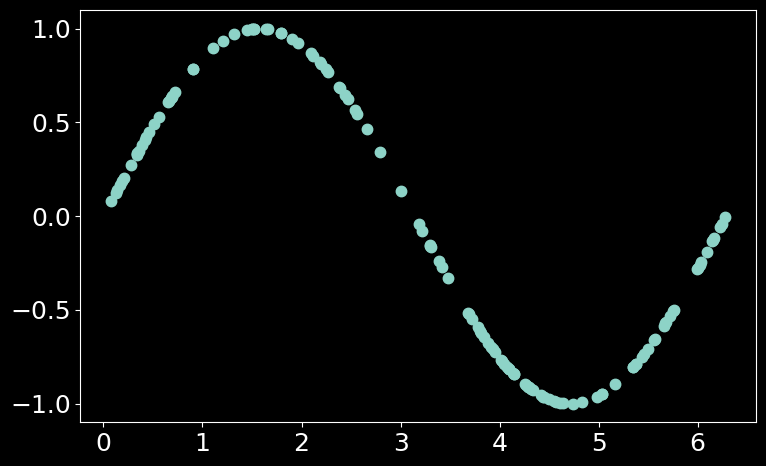

In [2]:
train_data_length = 128
train_data = torch.zeros((train_data_length,2))
train_data[:,0] = 2*math.pi*torch.rand(train_data_length)
train_data[:,1] = torch.sin(train_data[:,0])
train_labels = torch.zeros(train_data_length)
trainset = [(train_data[i], train_labels[i]) for i in range(train_data_length)]
figure(5,8)
plt.plot(train_data[:, 0], train_data[:, 1], '.')
plt.tight_layout()

As usual, we need to define a `DataLoader` that will provide us with the training data in different batches.

In [3]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

First, we define the generator, which is fed with random data from a latent space. Its role is to generate data resembling the real samples. In this example, you have a two-dimensional latent space, so that the generator is fed with random $(z_{1}, z_{2})$ pairs and is required to transform them so that they resemble the real samples.

We can define any type of network in the generator, given that it has sufficient complexity to generate the underlying type of data.

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),            
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [5]:
generator = Generator()

In turn, the discriminator is fed with either real samples from the training dataset or generated samples provided by the generator. Its role will be to estimate the probability that the input belongs to the real dataset or is a generated one. The training is performed so that the discriminator outputs 1 when it is fed a real sample and 0 when it is fed a generated sample. Again, we can choose any architecture of our liking for this network.

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
discriminator = Discriminator()

We can now define our training hyper-parameters that will condition the learning procedure.

In [8]:
lr = 0.001
num_epochs = 5000
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Here, our goal is to understand and implement the training procedure for this simple type of GAN.

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.1 - GAN Training implementation

> We divide the training procedure into several steps that will all be successively applied within one iteration loop.

> 1. Generate data from random latent positions
> 2. Prepare the labels for training
> 3. Apply training and loss for the discriminator
> 4. Apply training and loss for the generator
    
</div>

***

In [9]:
loss_d = torch.zeros(int(num_epochs / 10))
loss_g = torch.zeros(int(num_epochs / 10))

import tqdm
from tqdm import tqdm

for epoch in tqdm(range(num_epochs), leave=False):
    for n, (real_samples, _) in enumerate(train_loader):

        discriminator.zero_grad()
        output_discriminator_real = discriminator(real_samples)
        loss_discriminator_real = loss_function(output_discriminator_real, torch.ones((batch_size, 1)))
        loss_discriminator_real.backward()

        random_samples = torch.randn((batch_size, 2))
        fake_samples = generator(random_samples)
        output_discriminator_fake = discriminator(fake_samples)
        loss_discriminator_fake = loss_function(output_discriminator_fake, torch.zeros((batch_size, 1)))
        loss_discriminator_fake.backward()

        loss_discriminator = loss_discriminator_real + loss_discriminator_fake
        optimizer_discriminator.step()

        generator.zero_grad()
        output_generator_fake = generator(random_samples)
        output_discriminator_fake = discriminator(output_generator_fake)
        loss_generator = loss_function(output_discriminator_fake, torch.ones((batch_size, 1)))
        loss_generator.backward()
        optimizer_generator.step()

    # Show loss
    if epoch % 10 == 0: # and n == batch_size - 1:
        loss_d[int(epoch / 10)] = loss_discriminator
        loss_g[int(epoch / 10)] = loss_generator
        tqdm.write(f"Epoch: {epoch}. Loss D.: {loss_discriminator}. Loss G.: {loss_generator}")

  0%|          | 12/5000 [00:01<05:22, 15.46it/s] 

Epoch: 0. Loss D.: 1.200974464416504. Loss G.: 0.7756893634796143
Epoch: 10. Loss D.: 0.9420979022979736. Loss G.: 2.6588189601898193
Epoch: 20. Loss D.: 0.8440399765968323. Loss G.: 1.4706392288208008


  1%|          | 45/5000 [00:01<01:26, 57.40it/s]

Epoch: 30. Loss D.: 0.9738617539405823. Loss G.: 1.4410758018493652
Epoch: 40. Loss D.: 0.9661845564842224. Loss G.: 1.0725682973861694
Epoch: 50. Loss D.: 1.0428789854049683. Loss G.: 1.0399857759475708


  2%|▏         | 78/5000 [00:01<00:56, 86.79it/s]

Epoch: 60. Loss D.: 1.427039384841919. Loss G.: 0.7491137981414795
Epoch: 70. Loss D.: 1.273842215538025. Loss G.: 0.8876165747642517
Epoch: 80. Loss D.: 1.2886111736297607. Loss G.: 0.8920490741729736


  2%|▏         | 111/5000 [00:01<00:50, 97.07it/s]

Epoch: 90. Loss D.: 1.3483725786209106. Loss G.: 0.8750400543212891
Epoch: 100. Loss D.: 1.1024665832519531. Loss G.: 1.2852104902267456
Epoch: 110. Loss D.: 1.2222154140472412. Loss G.: 1.0213383436203003


  3%|▎         | 134/5000 [00:02<00:46, 105.41it/s]

Epoch: 120. Loss D.: 1.351398229598999. Loss G.: 0.838279128074646
Epoch: 130. Loss D.: 1.3612173795700073. Loss G.: 0.9804956316947937
Epoch: 140. Loss D.: 1.1333000659942627. Loss G.: 0.9870333671569824


  3%|▎         | 167/5000 [00:02<00:44, 107.69it/s]

Epoch: 150. Loss D.: 1.4727048873901367. Loss G.: 0.9693067669868469
Epoch: 160. Loss D.: 1.2739026546478271. Loss G.: 0.7557661533355713
Epoch: 170. Loss D.: 1.2006802558898926. Loss G.: 0.861217737197876


  4%|▍         | 200/5000 [00:02<00:46, 103.78it/s]

Epoch: 180. Loss D.: 1.321794033050537. Loss G.: 1.0162445306777954
Epoch: 190. Loss D.: 1.220923662185669. Loss G.: 0.8764182925224304
Epoch: 200. Loss D.: 1.248629093170166. Loss G.: 0.7751212120056152


  4%|▍         | 222/5000 [00:03<00:46, 101.96it/s]

Epoch: 210. Loss D.: 1.262965440750122. Loss G.: 1.2353497743606567
Epoch: 220. Loss D.: 1.160832166671753. Loss G.: 0.7726531624794006


  5%|▍         | 244/5000 [00:03<00:47, 100.53it/s]

Epoch: 230. Loss D.: 1.2066236734390259. Loss G.: 1.1151853799819946
Epoch: 240. Loss D.: 1.2677619457244873. Loss G.: 0.816426157951355


Epoch: 250. Loss D.: 1.2491049766540527. Loss G.: 0.9340642690658569
Epoch: 260. Loss D.: 1.3545536994934082. Loss G.: 1.0343492031097412
Epoch: 270. Loss D.: 1.2691900730133057. Loss G.: 0.9872015714645386


  6%|▌         | 296/5000 [00:03<00:47, 99.33it/s]

Epoch: 280. Loss D.: 1.4243016242980957. Loss G.: 0.7884683012962341
Epoch: 290. Loss D.: 1.239332914352417. Loss G.: 0.7865183353424072


  6%|▋         | 316/5000 [00:03<00:47, 98.71it/s]

Epoch: 300. Loss D.: 1.2481050491333008. Loss G.: 0.9612160325050354
Epoch: 310. Loss D.: 1.2938134670257568. Loss G.: 0.868432879447937


  7%|▋         | 337/5000 [00:04<00:47, 99.08it/s]

Epoch: 320. Loss D.: 1.2753150463104248. Loss G.: 0.9636877775192261
Epoch: 330. Loss D.: 1.245959758758545. Loss G.: 0.8906716704368591


  7%|▋         | 358/5000 [00:04<00:46, 99.59it/s]

Epoch: 340. Loss D.: 1.497426986694336. Loss G.: 0.6327502727508545
Epoch: 350. Loss D.: 1.2490763664245605. Loss G.: 0.7532829642295837
Epoch: 360. Loss D.: 1.3358705043792725. Loss G.: 0.800078809261322


  8%|▊         | 391/5000 [00:04<00:45, 101.91it/s]

Epoch: 370. Loss D.: 1.185456395149231. Loss G.: 0.8987606763839722
Epoch: 380. Loss D.: 1.274561882019043. Loss G.: 0.8121846914291382
Epoch: 390. Loss D.: 1.2467358112335205. Loss G.: 1.0133638381958008


  8%|▊         | 413/5000 [00:05<00:45, 100.07it/s]

Epoch: 400. Loss D.: 1.3323506116867065. Loss G.: 0.7410114407539368
Epoch: 410. Loss D.: 1.3573594093322754. Loss G.: 0.7447794675827026
Epoch: 420. Loss D.: 1.3863513469696045. Loss G.: 0.865827739238739


  9%|▉         | 445/5000 [00:05<00:45, 100.85it/s]

Epoch: 430. Loss D.: 1.3561102151870728. Loss G.: 0.7442354559898376
Epoch: 440. Loss D.: 1.3370978832244873. Loss G.: 0.6705453395843506


  9%|▉         | 466/5000 [00:05<00:46, 98.51it/s] 

Epoch: 450. Loss D.: 1.330613374710083. Loss G.: 0.7442034482955933
Epoch: 460. Loss D.: 1.3254914283752441. Loss G.: 0.7507797479629517


 10%|▉         | 487/5000 [00:05<00:45, 99.82it/s]

Epoch: 470. Loss D.: 1.3672246932983398. Loss G.: 0.6935149431228638
Epoch: 480. Loss D.: 1.3343839645385742. Loss G.: 0.7533605098724365
Epoch: 490. Loss D.: 1.3600940704345703. Loss G.: 0.6896383762359619


 10%|█         | 517/5000 [00:05<00:45, 98.16it/s]

Epoch: 500. Loss D.: 1.429330825805664. Loss G.: 0.7159966826438904
Epoch: 510. Loss D.: 1.3811427354812622. Loss G.: 0.7183549404144287


 11%|█         | 537/5000 [00:06<00:45, 97.09it/s]

Epoch: 520. Loss D.: 1.3515715599060059. Loss G.: 0.6914567351341248
Epoch: 530. Loss D.: 1.347067952156067. Loss G.: 0.693253219127655


 11%|█         | 558/5000 [00:06<00:44, 99.80it/s]

Epoch: 540. Loss D.: 1.386467456817627. Loss G.: 0.7102982997894287
Epoch: 550. Loss D.: 1.3567371368408203. Loss G.: 0.7242331504821777
Epoch: 560. Loss D.: 1.392258644104004. Loss G.: 0.7112936973571777


 12%|█▏        | 588/5000 [00:06<00:44, 98.73it/s]

Epoch: 570. Loss D.: 1.3417389392852783. Loss G.: 0.7003312706947327
Epoch: 580. Loss D.: 1.4469859600067139. Loss G.: 0.6837252378463745


 12%|█▏        | 608/5000 [00:06<00:44, 98.75it/s]

Epoch: 590. Loss D.: 1.320473551750183. Loss G.: 0.8030005693435669
Epoch: 600. Loss D.: 1.379921555519104. Loss G.: 0.70037841796875
Epoch: 610. Loss D.: 1.3949840068817139. Loss G.: 0.7140282988548279


 13%|█▎        | 639/5000 [00:07<00:44, 98.67it/s]

Epoch: 620. Loss D.: 1.381330966949463. Loss G.: 0.6588761210441589
Epoch: 630. Loss D.: 1.3562312126159668. Loss G.: 0.7676035165786743


 13%|█▎        | 659/5000 [00:07<00:45, 95.27it/s]

Epoch: 640. Loss D.: 1.3886754512786865. Loss G.: 0.6832296848297119
Epoch: 650. Loss D.: 1.3864104747772217. Loss G.: 0.8204202055931091


 14%|█▎        | 679/5000 [00:07<00:45, 94.99it/s]

Epoch: 660. Loss D.: 1.3890939950942993. Loss G.: 0.6680346131324768
Epoch: 670. Loss D.: 1.4023321866989136. Loss G.: 0.7029314041137695


 14%|█▍        | 699/5000 [00:07<00:46, 92.54it/s]

Epoch: 680. Loss D.: 1.4048259258270264. Loss G.: 0.6872075200080872
Epoch: 690. Loss D.: 1.3731849193572998. Loss G.: 0.6903232336044312


 14%|█▍        | 719/5000 [00:08<00:45, 94.30it/s]

Epoch: 700. Loss D.: 1.400006651878357. Loss G.: 0.7215524911880493
Epoch: 710. Loss D.: 1.3885159492492676. Loss G.: 0.6936025619506836


 15%|█▍        | 740/5000 [00:08<00:43, 97.33it/s]

Epoch: 720. Loss D.: 1.375237226486206. Loss G.: 0.7101967930793762
Epoch: 730. Loss D.: 1.4003119468688965. Loss G.: 0.7167725563049316


 15%|█▌        | 750/5000 [00:08<00:45, 93.36it/s]

Epoch: 740. Loss D.: 1.320603847503662. Loss G.: 0.7041237354278564
Epoch: 750. Loss D.: 1.3420741558074951. Loss G.: 0.6743991374969482


 16%|█▌        | 781/5000 [00:08<00:43, 97.63it/s]

Epoch: 760. Loss D.: 1.2765599489212036. Loss G.: 0.7821160554885864
Epoch: 770. Loss D.: 1.2936482429504395. Loss G.: 0.7561797499656677
Epoch: 780. Loss D.: 1.3584142923355103. Loss G.: 0.7207483649253845


 16%|█▌        | 802/5000 [00:09<00:42, 98.79it/s]

Epoch: 790. Loss D.: 1.4114696979522705. Loss G.: 0.6915006637573242
Epoch: 800. Loss D.: 1.31288743019104. Loss G.: 0.7017707824707031
Epoch: 810. Loss D.: 1.3411877155303955. Loss G.: 0.7501019239425659


 17%|█▋        | 832/5000 [00:09<00:42, 97.21it/s]

Epoch: 820. Loss D.: 1.3591721057891846. Loss G.: 0.717818021774292
Epoch: 830. Loss D.: 1.3311457633972168. Loss G.: 0.7278383374214172


 17%|█▋        | 853/5000 [00:09<00:43, 95.50it/s]

Epoch: 840. Loss D.: 1.3665094375610352. Loss G.: 0.7390958070755005
Epoch: 850. Loss D.: 1.3587589263916016. Loss G.: 0.734306812286377


Epoch: 860. Loss D.: 1.3906055688858032. Loss G.: 0.720476508140564
Epoch: 870. Loss D.: 1.351975440979004. Loss G.: 0.8315247893333435
Epoch: 880. Loss D.: 1.310232400894165. Loss G.: 0.7873066663742065


 18%|█▊        | 906/5000 [00:10<00:40, 100.22it/s]

Epoch: 890. Loss D.: 1.3415629863739014. Loss G.: 0.7756909132003784
Epoch: 900. Loss D.: 1.4002766609191895. Loss G.: 0.7426986694335938
Epoch: 910. Loss D.: 1.3539330959320068. Loss G.: 0.751349925994873


 19%|█▉        | 938/5000 [00:10<00:40, 99.39it/s] 

Epoch: 920. Loss D.: 1.3021042346954346. Loss G.: 0.8433325886726379
Epoch: 930. Loss D.: 1.3290576934814453. Loss G.: 0.8659794926643372
Epoch: 940. Loss D.: 1.413835048675537. Loss G.: 0.8400003910064697


 19%|█▉        | 968/5000 [00:10<00:42, 95.80it/s]

Epoch: 950. Loss D.: 1.4045240879058838. Loss G.: 0.850200355052948
Epoch: 960. Loss D.: 1.1899656057357788. Loss G.: 1.0338952541351318


 20%|█▉        | 988/5000 [00:10<00:42, 94.54it/s]

Epoch: 970. Loss D.: 1.3275245428085327. Loss G.: 0.8327261805534363
Epoch: 980. Loss D.: 1.2532298564910889. Loss G.: 0.7882269620895386


 20%|██        | 1008/5000 [00:11<00:42, 94.46it/s]

Epoch: 990. Loss D.: 1.2760519981384277. Loss G.: 0.9406512379646301
Epoch: 1000. Loss D.: 1.2182673215866089. Loss G.: 0.8417599201202393


 21%|██        | 1028/5000 [00:11<00:41, 94.61it/s]

Epoch: 1010. Loss D.: 1.2450671195983887. Loss G.: 0.9697563648223877
Epoch: 1020. Loss D.: 1.3536114692687988. Loss G.: 0.8521085977554321


 21%|██        | 1049/5000 [00:11<00:41, 94.21it/s]

Epoch: 1030. Loss D.: 1.2092230319976807. Loss G.: 0.8417437672615051
Epoch: 1040. Loss D.: 1.3186876773834229. Loss G.: 0.7201904058456421


 21%|██▏       | 1069/5000 [00:11<00:41, 95.06it/s]

Epoch: 1050. Loss D.: 1.3718982934951782. Loss G.: 0.6907423138618469
Epoch: 1060. Loss D.: 1.2956795692443848. Loss G.: 0.8107675313949585


 22%|██▏       | 1090/5000 [00:11<00:40, 96.72it/s]

Epoch: 1070. Loss D.: 1.4198747873306274. Loss G.: 0.634889543056488
Epoch: 1080. Loss D.: 1.2856757640838623. Loss G.: 0.6904147863388062


 22%|██▏       | 1110/5000 [00:12<00:40, 96.35it/s]

Epoch: 1090. Loss D.: 1.3494060039520264. Loss G.: 0.7147520184516907
Epoch: 1100. Loss D.: 1.2544885873794556. Loss G.: 0.9507536888122559


 23%|██▎       | 1131/5000 [00:12<00:39, 98.88it/s]

Epoch: 1110. Loss D.: 1.2142157554626465. Loss G.: 0.9876789450645447
Epoch: 1120. Loss D.: 1.2921245098114014. Loss G.: 0.9337449073791504
Epoch: 1130. Loss D.: 1.2168934345245361. Loss G.: 0.8507958054542542


 23%|██▎       | 1151/5000 [00:12<00:40, 95.33it/s]

Epoch: 1140. Loss D.: 1.4312760829925537. Loss G.: 0.7871902585029602
Epoch: 1150. Loss D.: 1.2512842416763306. Loss G.: 1.1431186199188232


 23%|██▎       | 1171/5000 [00:12<00:40, 94.79it/s]

Epoch: 1160. Loss D.: 1.158247470855713. Loss G.: 1.0536446571350098
Epoch: 1170. Loss D.: 1.2375588417053223. Loss G.: 0.7981703281402588


 24%|██▍       | 1192/5000 [00:12<00:39, 96.55it/s]

Epoch: 1180. Loss D.: 1.5138423442840576. Loss G.: 0.7340989112854004
Epoch: 1190. Loss D.: 1.3741722106933594. Loss G.: 0.8273484110832214


 24%|██▍       | 1212/5000 [00:13<00:39, 96.87it/s]

Epoch: 1200. Loss D.: 1.3158719539642334. Loss G.: 0.8704503178596497
Epoch: 1210. Loss D.: 1.2235682010650635. Loss G.: 0.7594384551048279


 25%|██▍       | 1233/5000 [00:13<00:38, 97.94it/s]

Epoch: 1220. Loss D.: 1.2872494459152222. Loss G.: 0.729419469833374
Epoch: 1230. Loss D.: 1.2217333316802979. Loss G.: 1.0915076732635498


 25%|██▌       | 1253/5000 [00:13<00:40, 93.67it/s]

Epoch: 1240. Loss D.: 1.5423235893249512. Loss G.: 0.7263081073760986
Epoch: 1250. Loss D.: 1.2209086418151855. Loss G.: 0.9353728294372559


 25%|██▌       | 1273/5000 [00:13<00:39, 94.52it/s]

Epoch: 1260. Loss D.: 1.1273131370544434. Loss G.: 0.8730602264404297
Epoch: 1270. Loss D.: 1.2677385807037354. Loss G.: 0.9241317510604858


 26%|██▌       | 1293/5000 [00:14<00:39, 94.37it/s]

Epoch: 1280. Loss D.: 1.2983121871948242. Loss G.: 0.9330308437347412
Epoch: 1290. Loss D.: 1.3377211093902588. Loss G.: 0.9185432195663452


 26%|██▋       | 1313/5000 [00:14<00:39, 93.65it/s]

Epoch: 1300. Loss D.: 1.354386329650879. Loss G.: 0.7957804203033447
Epoch: 1310. Loss D.: 1.335965633392334. Loss G.: 0.7367191314697266


 27%|██▋       | 1333/5000 [00:14<00:39, 93.19it/s]

Epoch: 1320. Loss D.: 1.3572019338607788. Loss G.: 0.8579745888710022
Epoch: 1330. Loss D.: 1.3054447174072266. Loss G.: 0.8459845781326294


 27%|██▋       | 1353/5000 [00:14<00:38, 94.01it/s]

Epoch: 1340. Loss D.: 1.3239840269088745. Loss G.: 0.7399548888206482
Epoch: 1350. Loss D.: 1.3242905139923096. Loss G.: 0.8784878253936768


 27%|██▋       | 1373/5000 [00:14<00:38, 95.05it/s]

Epoch: 1360. Loss D.: 1.201432228088379. Loss G.: 0.9518725872039795
Epoch: 1370. Loss D.: 1.4106755256652832. Loss G.: 0.7536377906799316


 28%|██▊       | 1393/5000 [00:15<00:38, 94.85it/s]

Epoch: 1380. Loss D.: 1.2838923931121826. Loss G.: 0.8808704614639282
Epoch: 1390. Loss D.: 1.2662044763565063. Loss G.: 0.9749770164489746


 28%|██▊       | 1413/5000 [00:15<00:37, 95.02it/s]

Epoch: 1400. Loss D.: 1.4493029117584229. Loss G.: 0.7415536642074585
Epoch: 1410. Loss D.: 1.387601375579834. Loss G.: 0.7044637203216553


 29%|██▊       | 1433/5000 [00:15<00:38, 93.18it/s]

Epoch: 1420. Loss D.: 1.268388032913208. Loss G.: 0.8632383346557617
Epoch: 1430. Loss D.: 1.3311712741851807. Loss G.: 0.8111761808395386


 29%|██▉       | 1453/5000 [00:15<00:37, 94.51it/s]

Epoch: 1440. Loss D.: 1.2480313777923584. Loss G.: 0.8919187784194946
Epoch: 1450. Loss D.: 1.3083363771438599. Loss G.: 0.8221501111984253


 29%|██▉       | 1473/5000 [00:15<00:37, 93.38it/s]

Epoch: 1460. Loss D.: 1.4309684038162231. Loss G.: 0.7232211828231812
Epoch: 1470. Loss D.: 1.3554607629776. Loss G.: 0.7955985069274902


 30%|██▉       | 1493/5000 [00:16<00:37, 93.34it/s]

Epoch: 1480. Loss D.: 1.3761694431304932. Loss G.: 0.9087465405464172
Epoch: 1490. Loss D.: 1.269207239151001. Loss G.: 0.918904185295105


 30%|███       | 1513/5000 [00:16<00:37, 93.79it/s]

Epoch: 1500. Loss D.: 1.4279943704605103. Loss G.: 0.7200424671173096
Epoch: 1510. Loss D.: 1.3949244022369385. Loss G.: 0.7131543755531311


 31%|███       | 1533/5000 [00:16<00:36, 94.45it/s]

Epoch: 1520. Loss D.: 1.3226804733276367. Loss G.: 0.7908503413200378
Epoch: 1530. Loss D.: 1.2457876205444336. Loss G.: 0.9438239336013794


 31%|███       | 1553/5000 [00:16<00:36, 95.38it/s]

Epoch: 1540. Loss D.: 1.272681474685669. Loss G.: 1.1057872772216797
Epoch: 1550. Loss D.: 1.314955234527588. Loss G.: 0.8992980122566223


 31%|███▏      | 1573/5000 [00:17<00:37, 91.88it/s]

Epoch: 1560. Loss D.: 1.3508731126785278. Loss G.: 1.0361438989639282
Epoch: 1570. Loss D.: 1.2985961437225342. Loss G.: 0.707553505897522


 32%|███▏      | 1593/5000 [00:17<00:36, 92.71it/s]

Epoch: 1580. Loss D.: 1.3441894054412842. Loss G.: 0.8132777810096741
Epoch: 1590. Loss D.: 1.4077874422073364. Loss G.: 0.7724761962890625


 32%|███▏      | 1613/5000 [00:17<00:36, 93.43it/s]

Epoch: 1600. Loss D.: 1.321265459060669. Loss G.: 0.7624372839927673
Epoch: 1610. Loss D.: 1.2556886672973633. Loss G.: 0.8073237538337708


 33%|███▎      | 1633/5000 [00:17<00:36, 92.64it/s]

Epoch: 1620. Loss D.: 1.2894258499145508. Loss G.: 0.8031469583511353
Epoch: 1630. Loss D.: 1.3590819835662842. Loss G.: 0.7873021364212036


 33%|███▎      | 1653/5000 [00:17<00:35, 94.30it/s]

Epoch: 1640. Loss D.: 1.3682401180267334. Loss G.: 0.7720619440078735
Epoch: 1650. Loss D.: 1.3362905979156494. Loss G.: 0.715628981590271


 33%|███▎      | 1673/5000 [00:18<00:35, 94.41it/s]

Epoch: 1660. Loss D.: 1.327439785003662. Loss G.: 0.9186552166938782
Epoch: 1670. Loss D.: 1.34474778175354. Loss G.: 0.8118135929107666


 34%|███▍      | 1693/5000 [00:18<00:35, 93.78it/s]

Epoch: 1680. Loss D.: 1.300192952156067. Loss G.: 0.7946779131889343
Epoch: 1690. Loss D.: 1.175773024559021. Loss G.: 1.1107025146484375


 34%|███▍      | 1713/5000 [00:18<00:35, 93.62it/s]

Epoch: 1700. Loss D.: 1.253231406211853. Loss G.: 0.9171170592308044
Epoch: 1710. Loss D.: 1.3745572566986084. Loss G.: 0.7516956329345703


 35%|███▍      | 1733/5000 [00:18<00:34, 95.72it/s]

Epoch: 1720. Loss D.: 1.338547945022583. Loss G.: 0.703379213809967
Epoch: 1730. Loss D.: 1.3292818069458008. Loss G.: 0.8333226442337036


 35%|███▌      | 1753/5000 [00:18<00:33, 95.51it/s]

Epoch: 1740. Loss D.: 1.4094438552856445. Loss G.: 0.6592779159545898
Epoch: 1750. Loss D.: 1.1500760316848755. Loss G.: 1.1218928098678589


 35%|███▌      | 1773/5000 [00:19<00:33, 96.10it/s]

Epoch: 1760. Loss D.: 1.364599585533142. Loss G.: 0.7376723885536194
Epoch: 1770. Loss D.: 1.2817275524139404. Loss G.: 0.7767050862312317


 36%|███▌      | 1793/5000 [00:19<00:33, 95.40it/s]

Epoch: 1780. Loss D.: 1.3439583778381348. Loss G.: 0.7309500575065613
Epoch: 1790. Loss D.: 1.3027279376983643. Loss G.: 1.0017330646514893


 36%|███▋      | 1813/5000 [00:19<00:34, 92.99it/s]

Epoch: 1800. Loss D.: 1.2797133922576904. Loss G.: 0.9894213080406189
Epoch: 1810. Loss D.: 1.3255536556243896. Loss G.: 0.8754362463951111


 37%|███▋      | 1833/5000 [00:19<00:34, 92.76it/s]

Epoch: 1820. Loss D.: 1.3513860702514648. Loss G.: 0.7696428298950195
Epoch: 1830. Loss D.: 1.360095739364624. Loss G.: 0.7760263681411743


 37%|███▋      | 1853/5000 [00:20<00:34, 91.15it/s]

Epoch: 1840. Loss D.: 1.2353153228759766. Loss G.: 0.9286227822303772
Epoch: 1850. Loss D.: 1.2149330377578735. Loss G.: 1.1245391368865967


 37%|███▋      | 1873/5000 [00:20<00:33, 92.44it/s]

Epoch: 1860. Loss D.: 1.3846845626831055. Loss G.: 0.8269689679145813
Epoch: 1870. Loss D.: 1.3219327926635742. Loss G.: 1.015149474143982


 38%|███▊      | 1893/5000 [00:20<00:33, 91.92it/s]

Epoch: 1880. Loss D.: 1.1396851539611816. Loss G.: 1.0100462436676025
Epoch: 1890. Loss D.: 1.264248251914978. Loss G.: 0.9170617461204529


 38%|███▊      | 1913/5000 [00:20<00:32, 93.82it/s]

Epoch: 1900. Loss D.: 1.2808682918548584. Loss G.: 0.8336530923843384
Epoch: 1910. Loss D.: 1.2566840648651123. Loss G.: 0.8742659091949463


 39%|███▊      | 1933/5000 [00:20<00:33, 92.01it/s]

Epoch: 1920. Loss D.: 1.333182454109192. Loss G.: 0.7509016990661621
Epoch: 1930. Loss D.: 1.3064782619476318. Loss G.: 1.1296970844268799


 39%|███▉      | 1953/5000 [00:21<00:32, 93.38it/s]

Epoch: 1940. Loss D.: 1.2822363376617432. Loss G.: 0.7519978880882263
Epoch: 1950. Loss D.: 1.4192068576812744. Loss G.: 0.7173865437507629


 39%|███▉      | 1973/5000 [00:21<00:32, 93.65it/s]

Epoch: 1960. Loss D.: 1.3335559368133545. Loss G.: 0.7323330640792847
Epoch: 1970. Loss D.: 1.3242011070251465. Loss G.: 0.8903370499610901


 40%|███▉      | 1993/5000 [00:21<00:32, 92.79it/s]

Epoch: 1980. Loss D.: 1.330243706703186. Loss G.: 0.9207071661949158
Epoch: 1990. Loss D.: 1.4979279041290283. Loss G.: 0.900367259979248


 40%|████      | 2013/5000 [00:21<00:32, 93.30it/s]

Epoch: 2000. Loss D.: 1.343909740447998. Loss G.: 0.840651273727417
Epoch: 2010. Loss D.: 1.468381643295288. Loss G.: 0.6972786784172058


 41%|████      | 2033/5000 [00:21<00:32, 92.59it/s]

Epoch: 2020. Loss D.: 1.324946403503418. Loss G.: 0.8980517387390137
Epoch: 2030. Loss D.: 1.4022884368896484. Loss G.: 0.740437388420105


 41%|████      | 2053/5000 [00:22<00:31, 92.64it/s]

Epoch: 2040. Loss D.: 1.5376310348510742. Loss G.: 0.7001171112060547
Epoch: 2050. Loss D.: 1.4254508018493652. Loss G.: 1.1116067171096802


 41%|████▏     | 2073/5000 [00:22<00:31, 94.33it/s]

Epoch: 2060. Loss D.: 1.2847801446914673. Loss G.: 0.9443767666816711
Epoch: 2070. Loss D.: 1.4844646453857422. Loss G.: 0.7362995743751526


 42%|████▏     | 2093/5000 [00:22<00:30, 95.15it/s]

Epoch: 2080. Loss D.: 1.2845897674560547. Loss G.: 0.8859013319015503
Epoch: 2090. Loss D.: 1.480020523071289. Loss G.: 0.8432108759880066


 42%|████▏     | 2114/5000 [00:22<00:29, 97.19it/s]

Epoch: 2100. Loss D.: 1.0990476608276367. Loss G.: 1.0322527885437012
Epoch: 2110. Loss D.: 1.1016998291015625. Loss G.: 1.0582562685012817


 43%|████▎     | 2134/5000 [00:23<00:30, 94.71it/s]

Epoch: 2120. Loss D.: 1.3006463050842285. Loss G.: 0.9048221111297607
Epoch: 2130. Loss D.: 1.108988642692566. Loss G.: 0.8324488401412964


 43%|████▎     | 2154/5000 [00:23<00:30, 93.66it/s]

Epoch: 2140. Loss D.: 1.1090331077575684. Loss G.: 1.2335890531539917
Epoch: 2150. Loss D.: 1.1182382106781006. Loss G.: 1.0594431161880493


 43%|████▎     | 2174/5000 [00:23<00:30, 93.64it/s]

Epoch: 2160. Loss D.: 1.2922625541687012. Loss G.: 1.0883090496063232
Epoch: 2170. Loss D.: 1.2940350770950317. Loss G.: 0.9652374982833862


 44%|████▍     | 2194/5000 [00:23<00:29, 94.16it/s]

Epoch: 2180. Loss D.: 1.3441662788391113. Loss G.: 0.9040402173995972
Epoch: 2190. Loss D.: 1.304825782775879. Loss G.: 0.7196690440177917


 44%|████▍     | 2214/5000 [00:23<00:29, 94.08it/s]

Epoch: 2200. Loss D.: 1.3184514045715332. Loss G.: 0.786520779132843
Epoch: 2210. Loss D.: 1.2312538623809814. Loss G.: 0.8783495426177979


 45%|████▍     | 2234/5000 [00:24<00:30, 91.14it/s]

Epoch: 2220. Loss D.: 1.4207218885421753. Loss G.: 0.6801048517227173
Epoch: 2230. Loss D.: 1.1574022769927979. Loss G.: 0.9142313599586487


 45%|████▌     | 2254/5000 [00:24<00:29, 93.09it/s]

Epoch: 2240. Loss D.: 1.216981053352356. Loss G.: 0.9118596315383911
Epoch: 2250. Loss D.: 1.1675653457641602. Loss G.: 0.8079111576080322


 45%|████▌     | 2274/5000 [00:24<00:29, 93.47it/s]

Epoch: 2260. Loss D.: 1.2004656791687012. Loss G.: 0.907604455947876
Epoch: 2270. Loss D.: 1.1589982509613037. Loss G.: 1.079993724822998


 46%|████▌     | 2294/5000 [00:24<00:28, 95.16it/s]

Epoch: 2280. Loss D.: 1.268031120300293. Loss G.: 0.858462393283844
Epoch: 2290. Loss D.: 1.3453104496002197. Loss G.: 0.9139498472213745


 46%|████▋     | 2314/5000 [00:24<00:28, 95.18it/s]

Epoch: 2300. Loss D.: 1.2412647008895874. Loss G.: 0.8563605546951294
Epoch: 2310. Loss D.: 1.3280912637710571. Loss G.: 0.7081623077392578


 47%|████▋     | 2334/5000 [00:25<00:28, 92.62it/s]

Epoch: 2320. Loss D.: 1.242178201675415. Loss G.: 0.91474449634552
Epoch: 2330. Loss D.: 1.1440558433532715. Loss G.: 0.86939537525177


 47%|████▋     | 2354/5000 [00:25<00:28, 93.87it/s]

Epoch: 2340. Loss D.: 1.393543004989624. Loss G.: 1.070950984954834
Epoch: 2350. Loss D.: 1.263850450515747. Loss G.: 0.9500088691711426


 47%|████▋     | 2374/5000 [00:25<00:27, 94.49it/s]

Epoch: 2360. Loss D.: 1.325177550315857. Loss G.: 0.9050142765045166
Epoch: 2370. Loss D.: 1.2267353534698486. Loss G.: 0.9974697828292847


 48%|████▊     | 2394/5000 [00:25<00:28, 91.84it/s]

Epoch: 2380. Loss D.: 1.496140718460083. Loss G.: 0.8006085157394409
Epoch: 2390. Loss D.: 1.0711160898208618. Loss G.: 1.1786590814590454


 48%|████▊     | 2414/5000 [00:26<00:28, 92.31it/s]

Epoch: 2400. Loss D.: 1.2649762630462646. Loss G.: 0.9058324694633484
Epoch: 2410. Loss D.: 1.1452035903930664. Loss G.: 0.9047101736068726


 49%|████▊     | 2434/5000 [00:26<00:26, 95.06it/s]

Epoch: 2420. Loss D.: 1.352830171585083. Loss G.: 0.8188459277153015
Epoch: 2430. Loss D.: 1.3478667736053467. Loss G.: 0.9023679494857788


 49%|████▉     | 2454/5000 [00:26<00:26, 96.01it/s]

Epoch: 2440. Loss D.: 1.2762044668197632. Loss G.: 1.0189836025238037
Epoch: 2450. Loss D.: 1.142559289932251. Loss G.: 1.0303109884262085


 49%|████▉     | 2474/5000 [00:26<00:26, 94.67it/s]

Epoch: 2460. Loss D.: 1.2285130023956299. Loss G.: 0.8685355186462402
Epoch: 2470. Loss D.: 1.2302634716033936. Loss G.: 1.1059075593948364


 50%|████▉     | 2494/5000 [00:26<00:26, 95.54it/s]

Epoch: 2480. Loss D.: 1.3272109031677246. Loss G.: 0.966065526008606
Epoch: 2490. Loss D.: 1.371443748474121. Loss G.: 0.935705304145813


 50%|█████     | 2514/5000 [00:27<00:25, 95.91it/s]

Epoch: 2500. Loss D.: 1.2627986669540405. Loss G.: 0.9387662410736084
Epoch: 2510. Loss D.: 1.3363728523254395. Loss G.: 0.9321999549865723


 51%|█████     | 2534/5000 [00:27<00:26, 93.54it/s]

Epoch: 2520. Loss D.: 1.3452866077423096. Loss G.: 1.031627893447876
Epoch: 2530. Loss D.: 1.1750926971435547. Loss G.: 1.14732825756073


 51%|█████     | 2555/5000 [00:27<00:25, 96.82it/s]

Epoch: 2540. Loss D.: 1.0682597160339355. Loss G.: 0.9682159423828125
Epoch: 2550. Loss D.: 1.2345914840698242. Loss G.: 1.2693179845809937


 52%|█████▏    | 2575/5000 [00:27<00:24, 97.25it/s]

Epoch: 2560. Loss D.: 1.4055829048156738. Loss G.: 0.8438873291015625
Epoch: 2570. Loss D.: 1.2701225280761719. Loss G.: 0.7804811596870422


 52%|█████▏    | 2595/5000 [00:27<00:25, 94.77it/s]

Epoch: 2580. Loss D.: 1.4157390594482422. Loss G.: 0.7777153849601746
Epoch: 2590. Loss D.: 1.3256398439407349. Loss G.: 0.7812395095825195


 52%|█████▏    | 2615/5000 [00:28<00:24, 95.59it/s]

Epoch: 2600. Loss D.: 1.2924485206604004. Loss G.: 1.0718050003051758
Epoch: 2610. Loss D.: 1.1894985437393188. Loss G.: 1.021850347518921


 53%|█████▎    | 2635/5000 [00:28<00:24, 95.61it/s]

Epoch: 2620. Loss D.: 1.0850443840026855. Loss G.: 1.4107494354248047
Epoch: 2630. Loss D.: 1.2490062713623047. Loss G.: 0.8084583878517151
Epoch: 2640. Loss D.: 1.2559561729431152. Loss G.: 0.9197714328765869


 53%|█████▎    | 2666/5000 [00:28<00:24, 96.83it/s]

Epoch: 2650. Loss D.: 1.153846025466919. Loss G.: 1.1927632093429565
Epoch: 2660. Loss D.: 1.0392745733261108. Loss G.: 1.2785414457321167


 54%|█████▎    | 2687/5000 [00:28<00:23, 97.81it/s]

Epoch: 2670. Loss D.: 1.234681487083435. Loss G.: 1.0865901708602905
Epoch: 2680. Loss D.: 1.170100450515747. Loss G.: 0.9905604124069214


 54%|█████▍    | 2707/5000 [00:29<00:23, 95.98it/s]

Epoch: 2690. Loss D.: 1.2269225120544434. Loss G.: 1.2241063117980957
Epoch: 2700. Loss D.: 1.3833919763565063. Loss G.: 0.8190158605575562


 55%|█████▍    | 2727/5000 [00:29<00:23, 94.92it/s]

Epoch: 2710. Loss D.: 1.4179855585098267. Loss G.: 0.6735782027244568
Epoch: 2720. Loss D.: 1.0808086395263672. Loss G.: 1.070465087890625


 55%|█████▍    | 2747/5000 [00:29<00:23, 94.92it/s]

Epoch: 2730. Loss D.: 1.2274353504180908. Loss G.: 0.8041776418685913
Epoch: 2740. Loss D.: 1.4423428773880005. Loss G.: 0.7730544209480286


 55%|█████▌    | 2767/5000 [00:29<00:23, 94.07it/s]

Epoch: 2750. Loss D.: 1.3230414390563965. Loss G.: 0.7437363266944885
Epoch: 2760. Loss D.: 1.4129538536071777. Loss G.: 0.8070573210716248


 56%|█████▌    | 2787/5000 [00:29<00:23, 93.52it/s]

Epoch: 2770. Loss D.: 1.2946124076843262. Loss G.: 0.8582773804664612
Epoch: 2780. Loss D.: 1.2175652980804443. Loss G.: 0.862034022808075


 56%|█████▌    | 2807/5000 [00:30<00:23, 93.12it/s]

Epoch: 2790. Loss D.: 1.2365326881408691. Loss G.: 0.9080225229263306
Epoch: 2800. Loss D.: 1.1183477640151978. Loss G.: 1.0275214910507202


 57%|█████▋    | 2827/5000 [00:30<00:22, 95.07it/s]

Epoch: 2810. Loss D.: 1.335373878479004. Loss G.: 0.9888325929641724
Epoch: 2820. Loss D.: 1.3244967460632324. Loss G.: 0.9457539319992065


 57%|█████▋    | 2847/5000 [00:30<00:23, 92.89it/s]

Epoch: 2830. Loss D.: 1.4661483764648438. Loss G.: 0.7564767003059387
Epoch: 2840. Loss D.: 1.2356548309326172. Loss G.: 0.7673198580741882


 57%|█████▋    | 2867/5000 [00:30<00:23, 92.26it/s]

Epoch: 2850. Loss D.: 1.3276208639144897. Loss G.: 0.8608091473579407
Epoch: 2860. Loss D.: 1.2635740041732788. Loss G.: 0.8871047496795654


 58%|█████▊    | 2887/5000 [00:31<00:23, 90.00it/s]

Epoch: 2870. Loss D.: 1.3045430183410645. Loss G.: 0.8548787236213684
Epoch: 2880. Loss D.: 1.2864136695861816. Loss G.: 0.7707418203353882


 58%|█████▊    | 2907/5000 [00:31<00:22, 91.70it/s]

Epoch: 2890. Loss D.: 1.4731214046478271. Loss G.: 0.8115987181663513
Epoch: 2900. Loss D.: 1.3802087306976318. Loss G.: 0.9071789383888245


 59%|█████▊    | 2927/5000 [00:31<00:22, 93.51it/s]

Epoch: 2910. Loss D.: 1.3369652032852173. Loss G.: 0.8478666543960571
Epoch: 2920. Loss D.: 1.1768622398376465. Loss G.: 0.8721165060997009


 59%|█████▉    | 2947/5000 [00:31<00:22, 92.44it/s]

Epoch: 2930. Loss D.: 1.2186843156814575. Loss G.: 0.8833268880844116
Epoch: 2940. Loss D.: 1.2654954195022583. Loss G.: 1.056235909461975


 59%|█████▉    | 2967/5000 [00:31<00:21, 93.92it/s]

Epoch: 2950. Loss D.: 1.2299760580062866. Loss G.: 0.8876175880432129
Epoch: 2960. Loss D.: 1.2732199430465698. Loss G.: 1.3188328742980957


 60%|█████▉    | 2987/5000 [00:32<00:21, 94.28it/s]

Epoch: 2970. Loss D.: 1.023897647857666. Loss G.: 1.1515769958496094
Epoch: 2980. Loss D.: 1.216522455215454. Loss G.: 1.0182013511657715


 60%|██████    | 3007/5000 [00:32<00:21, 94.40it/s]

Epoch: 2990. Loss D.: 1.2023544311523438. Loss G.: 1.2022230625152588
Epoch: 3000. Loss D.: 1.1078431606292725. Loss G.: 1.2267262935638428


 61%|██████    | 3027/5000 [00:32<00:21, 93.63it/s]

Epoch: 3010. Loss D.: 1.1343119144439697. Loss G.: 1.0485907793045044
Epoch: 3020. Loss D.: 1.2682989835739136. Loss G.: 0.9331917762756348


 61%|██████    | 3048/5000 [00:32<00:20, 94.38it/s]

Epoch: 3030. Loss D.: 1.271712064743042. Loss G.: 0.8052672147750854
Epoch: 3040. Loss D.: 1.0586671829223633. Loss G.: 0.8639253377914429


 61%|██████▏   | 3068/5000 [00:32<00:20, 93.95it/s]

Epoch: 3050. Loss D.: 1.302074909210205. Loss G.: 0.8181493282318115
Epoch: 3060. Loss D.: 1.2112553119659424. Loss G.: 1.18350350856781


 62%|██████▏   | 3088/5000 [00:33<00:20, 94.10it/s]

Epoch: 3070. Loss D.: 1.3016122579574585. Loss G.: 1.172197937965393
Epoch: 3080. Loss D.: 1.0859363079071045. Loss G.: 1.0177788734436035


 62%|██████▏   | 3108/5000 [00:33<00:20, 94.41it/s]

Epoch: 3090. Loss D.: 1.3336446285247803. Loss G.: 0.9644107222557068
Epoch: 3100. Loss D.: 1.303255319595337. Loss G.: 0.8369340896606445


 63%|██████▎   | 3128/5000 [00:33<00:19, 94.89it/s]

Epoch: 3110. Loss D.: 1.1666700839996338. Loss G.: 0.8835563659667969
Epoch: 3120. Loss D.: 1.3607177734375. Loss G.: 0.8493623733520508


 63%|██████▎   | 3148/5000 [00:33<00:19, 96.61it/s]

Epoch: 3130. Loss D.: 1.3461287021636963. Loss G.: 0.7046917676925659
Epoch: 3140. Loss D.: 1.180068016052246. Loss G.: 1.0044224262237549


 63%|██████▎   | 3168/5000 [00:33<00:19, 94.67it/s]

Epoch: 3150. Loss D.: 1.3364073038101196. Loss G.: 0.9419405460357666
Epoch: 3160. Loss D.: 1.092131495475769. Loss G.: 1.0942058563232422


 64%|██████▍   | 3188/5000 [00:34<00:19, 93.59it/s]

Epoch: 3170. Loss D.: 1.3636960983276367. Loss G.: 0.9112592935562134
Epoch: 3180. Loss D.: 1.1372778415679932. Loss G.: 0.9865196347236633


 64%|██████▍   | 3208/5000 [00:34<00:18, 94.79it/s]

Epoch: 3190. Loss D.: 1.3528807163238525. Loss G.: 0.9836559295654297
Epoch: 3200. Loss D.: 1.1593388319015503. Loss G.: 1.5719540119171143


 65%|██████▍   | 3228/5000 [00:34<00:18, 95.34it/s]

Epoch: 3210. Loss D.: 1.0926376581192017. Loss G.: 1.118415117263794
Epoch: 3220. Loss D.: 1.174992322921753. Loss G.: 1.1120553016662598


 65%|██████▍   | 3248/5000 [00:34<00:18, 94.34it/s]

Epoch: 3230. Loss D.: 1.1185283660888672. Loss G.: 1.1505900621414185
Epoch: 3240. Loss D.: 1.3918784856796265. Loss G.: 0.8624876737594604


 65%|██████▌   | 3268/5000 [00:35<00:18, 94.17it/s]

Epoch: 3250. Loss D.: 1.1428064107894897. Loss G.: 1.1411112546920776
Epoch: 3260. Loss D.: 1.0996241569519043. Loss G.: 1.0767686367034912


 66%|██████▌   | 3288/5000 [00:35<00:18, 94.77it/s]

Epoch: 3270. Loss D.: 1.320737600326538. Loss G.: 0.8324223756790161
Epoch: 3280. Loss D.: 1.2624707221984863. Loss G.: 0.7330191135406494


 66%|██████▌   | 3308/5000 [00:35<00:17, 96.11it/s]

Epoch: 3290. Loss D.: 1.2977559566497803. Loss G.: 0.7930545210838318
Epoch: 3300. Loss D.: 1.270984411239624. Loss G.: 0.808100163936615


 67%|██████▋   | 3328/5000 [00:35<00:17, 94.21it/s]

Epoch: 3310. Loss D.: 1.168853998184204. Loss G.: 1.0262527465820312
Epoch: 3320. Loss D.: 1.0076775550842285. Loss G.: 1.0753058195114136


 67%|██████▋   | 3348/5000 [00:35<00:17, 92.99it/s]

Epoch: 3330. Loss D.: 1.219529390335083. Loss G.: 0.9106032252311707
Epoch: 3340. Loss D.: 1.3895219564437866. Loss G.: 0.9482542276382446


 67%|██████▋   | 3368/5000 [00:36<00:17, 93.95it/s]

Epoch: 3350. Loss D.: 1.1923027038574219. Loss G.: 1.290208101272583
Epoch: 3360. Loss D.: 1.1068017482757568. Loss G.: 1.09531831741333


 68%|██████▊   | 3388/5000 [00:36<00:17, 93.64it/s]

Epoch: 3370. Loss D.: 1.1549735069274902. Loss G.: 1.1019694805145264
Epoch: 3380. Loss D.: 1.0226078033447266. Loss G.: 0.9871389865875244


 68%|██████▊   | 3408/5000 [00:36<00:17, 92.43it/s]

Epoch: 3390. Loss D.: 1.241768717765808. Loss G.: 1.0664544105529785
Epoch: 3400. Loss D.: 1.3847310543060303. Loss G.: 0.8309845328330994


 69%|██████▊   | 3428/5000 [00:36<00:16, 94.88it/s]

Epoch: 3410. Loss D.: 1.372795581817627. Loss G.: 0.8159152865409851
Epoch: 3420. Loss D.: 1.254626989364624. Loss G.: 0.8267196416854858


 69%|██████▉   | 3448/5000 [00:36<00:16, 96.20it/s]

Epoch: 3430. Loss D.: 1.551363468170166. Loss G.: 0.8795013427734375
Epoch: 3440. Loss D.: 1.278075933456421. Loss G.: 0.8144589066505432


 69%|██████▉   | 3468/5000 [00:37<00:15, 96.74it/s]

Epoch: 3450. Loss D.: 1.3001611232757568. Loss G.: 0.7698531150817871
Epoch: 3460. Loss D.: 1.3528318405151367. Loss G.: 0.8357455730438232


 70%|██████▉   | 3488/5000 [00:37<00:15, 95.64it/s]

Epoch: 3470. Loss D.: 1.2667515277862549. Loss G.: 0.9691162109375
Epoch: 3480. Loss D.: 1.1229435205459595. Loss G.: 1.250768780708313


 70%|███████   | 3508/5000 [00:37<00:16, 92.99it/s]

Epoch: 3490. Loss D.: 1.354912519454956. Loss G.: 0.7814592123031616
Epoch: 3500. Loss D.: 1.3585724830627441. Loss G.: 0.8504526019096375


 71%|███████   | 3528/5000 [00:37<00:15, 92.77it/s]

Epoch: 3510. Loss D.: 1.2756187915802002. Loss G.: 0.9178018569946289
Epoch: 3520. Loss D.: 1.1635980606079102. Loss G.: 1.055196762084961


 71%|███████   | 3548/5000 [00:38<00:15, 92.98it/s]

Epoch: 3530. Loss D.: 1.5113372802734375. Loss G.: 0.8300647735595703
Epoch: 3540. Loss D.: 1.1822338104248047. Loss G.: 1.0732059478759766


 71%|███████▏  | 3568/5000 [00:38<00:16, 89.29it/s]

Epoch: 3550. Loss D.: 1.29884672164917. Loss G.: 0.8436189293861389
Epoch: 3560. Loss D.: 1.2024712562561035. Loss G.: 0.8357572555541992


 72%|███████▏  | 3588/5000 [00:38<00:15, 92.31it/s]

Epoch: 3570. Loss D.: 1.2636141777038574. Loss G.: 0.8703738451004028
Epoch: 3580. Loss D.: 1.468550205230713. Loss G.: 0.7371804714202881


 72%|███████▏  | 3608/5000 [00:38<00:14, 94.94it/s]

Epoch: 3590. Loss D.: 1.3599750995635986. Loss G.: 0.9569457769393921
Epoch: 3600. Loss D.: 1.2286438941955566. Loss G.: 0.7863050699234009


 73%|███████▎  | 3628/5000 [00:38<00:14, 92.33it/s]

Epoch: 3610. Loss D.: 1.2031068801879883. Loss G.: 0.8146113753318787
Epoch: 3620. Loss D.: 1.2493361234664917. Loss G.: 0.8871241807937622


 73%|███████▎  | 3648/5000 [00:39<00:14, 92.28it/s]

Epoch: 3630. Loss D.: 1.3488577604293823. Loss G.: 0.8388025164604187
Epoch: 3640. Loss D.: 1.3808964490890503. Loss G.: 0.8710491061210632


 73%|███████▎  | 3668/5000 [00:39<00:14, 91.26it/s]

Epoch: 3650. Loss D.: 1.3443536758422852. Loss G.: 0.7789073586463928
Epoch: 3660. Loss D.: 1.2045567035675049. Loss G.: 0.8282390236854553


 74%|███████▍  | 3688/5000 [00:39<00:14, 90.96it/s]

Epoch: 3670. Loss D.: 1.2162504196166992. Loss G.: 0.9813195466995239
Epoch: 3680. Loss D.: 1.3624764680862427. Loss G.: 0.8100425601005554


 74%|███████▍  | 3708/5000 [00:39<00:14, 91.50it/s]

Epoch: 3690. Loss D.: 1.2042927742004395. Loss G.: 1.1520594358444214
Epoch: 3700. Loss D.: 0.9876443147659302. Loss G.: 1.2408281564712524


 75%|███████▍  | 3728/5000 [00:39<00:13, 92.43it/s]

Epoch: 3710. Loss D.: 1.1328716278076172. Loss G.: 1.0018701553344727
Epoch: 3720. Loss D.: 1.0659618377685547. Loss G.: 1.0538270473480225


 75%|███████▍  | 3748/5000 [00:40<00:13, 93.75it/s]

Epoch: 3730. Loss D.: 1.0438874959945679. Loss G.: 1.1781399250030518
Epoch: 3740. Loss D.: 1.4396512508392334. Loss G.: 0.671700119972229


 75%|███████▌  | 3768/5000 [00:40<00:13, 92.72it/s]

Epoch: 3750. Loss D.: 1.234192132949829. Loss G.: 0.859189510345459
Epoch: 3760. Loss D.: 1.2339240312576294. Loss G.: 0.8596904277801514


 76%|███████▌  | 3788/5000 [00:40<00:13, 91.77it/s]

Epoch: 3770. Loss D.: 1.151907205581665. Loss G.: 0.8675894737243652
Epoch: 3780. Loss D.: 1.3161118030548096. Loss G.: 0.7777697443962097


 76%|███████▌  | 3808/5000 [00:40<00:12, 93.44it/s]

Epoch: 3790. Loss D.: 1.2170740365982056. Loss G.: 0.8927346467971802
Epoch: 3800. Loss D.: 1.1797188520431519. Loss G.: 1.2361640930175781


 77%|███████▋  | 3828/5000 [00:41<00:12, 94.36it/s]

Epoch: 3810. Loss D.: 1.2048600912094116. Loss G.: 1.0374541282653809
Epoch: 3820. Loss D.: 1.2825652360916138. Loss G.: 1.0244472026824951


 77%|███████▋  | 3848/5000 [00:41<00:12, 95.26it/s]

Epoch: 3830. Loss D.: 1.3211967945098877. Loss G.: 0.7762752175331116
Epoch: 3840. Loss D.: 1.2728251218795776. Loss G.: 0.6776289343833923


 77%|███████▋  | 3868/5000 [00:41<00:11, 95.64it/s]

Epoch: 3850. Loss D.: 1.28230881690979. Loss G.: 0.9165142178535461
Epoch: 3860. Loss D.: 1.3575797080993652. Loss G.: 0.7343596816062927


 78%|███████▊  | 3888/5000 [00:41<00:11, 94.22it/s]

Epoch: 3870. Loss D.: 1.25437593460083. Loss G.: 0.8724762201309204
Epoch: 3880. Loss D.: 1.232426404953003. Loss G.: 1.0514534711837769


 78%|███████▊  | 3908/5000 [00:41<00:11, 94.31it/s]

Epoch: 3890. Loss D.: 1.3375625610351562. Loss G.: 0.828435480594635
Epoch: 3900. Loss D.: 1.3212379217147827. Loss G.: 0.752240002155304


 79%|███████▊  | 3928/5000 [00:42<00:11, 93.75it/s]

Epoch: 3910. Loss D.: 1.18174409866333. Loss G.: 0.9726873636245728
Epoch: 3920. Loss D.: 1.2018182277679443. Loss G.: 1.043705940246582


 79%|███████▉  | 3948/5000 [00:42<00:11, 94.68it/s]

Epoch: 3930. Loss D.: 1.3314573764801025. Loss G.: 0.9379485845565796
Epoch: 3940. Loss D.: 1.339848518371582. Loss G.: 0.8615517616271973


 79%|███████▉  | 3968/5000 [00:42<00:10, 94.53it/s]

Epoch: 3950. Loss D.: 1.312056541442871. Loss G.: 0.8459970951080322
Epoch: 3960. Loss D.: 1.114661693572998. Loss G.: 0.9731460809707642


 80%|███████▉  | 3989/5000 [00:42<00:10, 96.27it/s]

Epoch: 3970. Loss D.: 1.330217719078064. Loss G.: 0.7709391117095947
Epoch: 3980. Loss D.: 1.3443818092346191. Loss G.: 0.8197765350341797


 80%|████████  | 4009/5000 [00:42<00:10, 95.55it/s]

Epoch: 3990. Loss D.: 1.1794564723968506. Loss G.: 0.9787092804908752
Epoch: 4000. Loss D.: 1.3535391092300415. Loss G.: 0.8777332901954651


 81%|████████  | 4029/5000 [00:43<00:10, 95.55it/s]

Epoch: 4010. Loss D.: 1.3786072731018066. Loss G.: 0.7895163893699646
Epoch: 4020. Loss D.: 1.3958038091659546. Loss G.: 0.7087010145187378


 81%|████████  | 4049/5000 [00:43<00:10, 94.20it/s]

Epoch: 4030. Loss D.: 1.4530202150344849. Loss G.: 0.7311956882476807
Epoch: 4040. Loss D.: 1.3342642784118652. Loss G.: 1.0619953870773315


 81%|████████▏ | 4069/5000 [00:43<00:09, 94.32it/s]

Epoch: 4050. Loss D.: 1.3315238952636719. Loss G.: 0.7653319239616394
Epoch: 4060. Loss D.: 1.4952946901321411. Loss G.: 0.7273595929145813


 82%|████████▏ | 4089/5000 [00:43<00:09, 93.92it/s]

Epoch: 4070. Loss D.: 1.3579990863800049. Loss G.: 0.7442180514335632
Epoch: 4080. Loss D.: 1.4111099243164062. Loss G.: 0.7737844586372375


 82%|████████▏ | 4109/5000 [00:44<00:09, 91.65it/s]

Epoch: 4090. Loss D.: 1.33095121383667. Loss G.: 0.8504530787467957
Epoch: 4100. Loss D.: 1.3841197490692139. Loss G.: 0.7342817187309265


 83%|████████▎ | 4129/5000 [00:44<00:09, 93.19it/s]

Epoch: 4110. Loss D.: 1.2600209712982178. Loss G.: 0.8513606190681458
Epoch: 4120. Loss D.: 1.3115792274475098. Loss G.: 0.8648663759231567


 83%|████████▎ | 4149/5000 [00:44<00:09, 94.04it/s]

Epoch: 4130. Loss D.: 1.3013536930084229. Loss G.: 0.8331882953643799
Epoch: 4140. Loss D.: 1.1596834659576416. Loss G.: 1.0680924654006958


 83%|████████▎ | 4169/5000 [00:44<00:08, 94.91it/s]

Epoch: 4150. Loss D.: 1.2668960094451904. Loss G.: 1.0807538032531738
Epoch: 4160. Loss D.: 1.1856958866119385. Loss G.: 1.073854923248291


 84%|████████▍ | 4189/5000 [00:44<00:08, 95.07it/s]

Epoch: 4170. Loss D.: 1.246761441230774. Loss G.: 0.7832151651382446
Epoch: 4180. Loss D.: 1.29201078414917. Loss G.: 1.0193240642547607


 84%|████████▍ | 4209/5000 [00:45<00:08, 93.50it/s]

Epoch: 4190. Loss D.: 1.3305461406707764. Loss G.: 0.8475453853607178
Epoch: 4200. Loss D.: 1.1447203159332275. Loss G.: 1.2167840003967285


 85%|████████▍ | 4229/5000 [00:45<00:08, 94.39it/s]

Epoch: 4210. Loss D.: 1.1946325302124023. Loss G.: 1.0504558086395264
Epoch: 4220. Loss D.: 1.2166061401367188. Loss G.: 1.083127498626709


 85%|████████▍ | 4249/5000 [00:45<00:08, 92.55it/s]

Epoch: 4230. Loss D.: 1.2808632850646973. Loss G.: 0.8449877500534058
Epoch: 4240. Loss D.: 1.2899956703186035. Loss G.: 0.7327828407287598


 85%|████████▌ | 4269/5000 [00:45<00:07, 92.81it/s]

Epoch: 4250. Loss D.: 1.2764673233032227. Loss G.: 0.9363712668418884
Epoch: 4260. Loss D.: 1.2817513942718506. Loss G.: 0.7966266870498657


 86%|████████▌ | 4290/5000 [00:45<00:07, 94.68it/s]

Epoch: 4270. Loss D.: 1.3148975372314453. Loss G.: 0.8520722389221191
Epoch: 4280. Loss D.: 1.2460360527038574. Loss G.: 0.9435918927192688


 86%|████████▌ | 4300/5000 [00:46<00:07, 92.70it/s]

Epoch: 4290. Loss D.: 1.3216321468353271. Loss G.: 0.8354682922363281
Epoch: 4300. Loss D.: 1.2992942333221436. Loss G.: 0.7971721887588501


 86%|████████▋ | 4320/5000 [00:46<00:07, 92.26it/s]

Epoch: 4310. Loss D.: 1.3289086818695068. Loss G.: 0.9023389220237732
Epoch: 4320. Loss D.: 1.2470967769622803. Loss G.: 0.8815097212791443


 87%|████████▋ | 4340/5000 [00:46<00:07, 91.39it/s]

Epoch: 4330. Loss D.: 1.1650199890136719. Loss G.: 1.0870354175567627
Epoch: 4340. Loss D.: 1.3923029899597168. Loss G.: 0.7764612436294556


 87%|████████▋ | 4362/5000 [00:46<00:06, 95.84it/s]

Epoch: 4350. Loss D.: 1.3854670524597168. Loss G.: 0.8311127424240112
Epoch: 4360. Loss D.: 1.4339690208435059. Loss G.: 0.7354894280433655
Epoch: 4370. Loss D.: 1.3609964847564697. Loss G.: 0.7754154801368713


 88%|████████▊ | 4392/5000 [00:47<00:06, 95.77it/s]

Epoch: 4380. Loss D.: 1.3137950897216797. Loss G.: 0.8428727984428406
Epoch: 4390. Loss D.: 1.3267639875411987. Loss G.: 0.808106005191803


 88%|████████▊ | 4412/5000 [00:47<00:06, 95.62it/s]

Epoch: 4400. Loss D.: 1.322037696838379. Loss G.: 0.7534371614456177
Epoch: 4410. Loss D.: 1.24167001247406. Loss G.: 0.8618159890174866


 89%|████████▊ | 4432/5000 [00:47<00:05, 95.56it/s]

Epoch: 4420. Loss D.: 1.4308125972747803. Loss G.: 0.8346128463745117
Epoch: 4430. Loss D.: 1.3220059871673584. Loss G.: 0.774653434753418


 89%|████████▉ | 4452/5000 [00:47<00:05, 94.18it/s]

Epoch: 4440. Loss D.: 1.2474303245544434. Loss G.: 0.7978078126907349
Epoch: 4450. Loss D.: 1.2911065816879272. Loss G.: 1.0798529386520386


 89%|████████▉ | 4472/5000 [00:47<00:05, 94.23it/s]

Epoch: 4460. Loss D.: 1.2423795461654663. Loss G.: 0.7880967259407043
Epoch: 4470. Loss D.: 1.3803664445877075. Loss G.: 0.6913279294967651


 90%|████████▉ | 4492/5000 [00:48<00:05, 92.22it/s]

Epoch: 4480. Loss D.: 1.0883283615112305. Loss G.: 0.9948639273643494
Epoch: 4490. Loss D.: 1.3296172618865967. Loss G.: 0.6941155195236206


 90%|█████████ | 4512/5000 [00:48<00:05, 91.78it/s]

Epoch: 4500. Loss D.: 1.41971755027771. Loss G.: 0.6958564519882202
Epoch: 4510. Loss D.: 1.1615614891052246. Loss G.: 0.8818984627723694


 91%|█████████ | 4532/5000 [00:48<00:05, 91.87it/s]

Epoch: 4520. Loss D.: 1.294710397720337. Loss G.: 0.9273576736450195
Epoch: 4530. Loss D.: 1.3597476482391357. Loss G.: 0.8124328851699829


 91%|█████████ | 4552/5000 [00:48<00:04, 92.78it/s]

Epoch: 4540. Loss D.: 1.4296249151229858. Loss G.: 0.6834489107131958
Epoch: 4550. Loss D.: 1.1927330493927002. Loss G.: 1.0779449939727783


 91%|█████████▏| 4572/5000 [00:48<00:04, 94.75it/s]

Epoch: 4560. Loss D.: 1.3013654947280884. Loss G.: 0.8261897563934326
Epoch: 4570. Loss D.: 1.3157906532287598. Loss G.: 0.8162141442298889


 92%|█████████▏| 4592/5000 [00:49<00:04, 94.46it/s]

Epoch: 4580. Loss D.: 1.276729941368103. Loss G.: 0.9923661947250366
Epoch: 4590. Loss D.: 1.2652419805526733. Loss G.: 0.8741517066955566


 92%|█████████▏| 4612/5000 [00:49<00:04, 95.94it/s]

Epoch: 4600. Loss D.: 1.2671282291412354. Loss G.: 0.9235973954200745
Epoch: 4610. Loss D.: 1.3057726621627808. Loss G.: 0.9309720396995544
Epoch: 4620. Loss D.: 1.2339175939559937. Loss G.: 0.8198747634887695


 93%|█████████▎| 4643/5000 [00:49<00:03, 93.86it/s]

Epoch: 4630. Loss D.: 1.2667001485824585. Loss G.: 0.8398219347000122
Epoch: 4640. Loss D.: 1.4093166589736938. Loss G.: 0.798378586769104


 93%|█████████▎| 4663/5000 [00:49<00:03, 93.97it/s]

Epoch: 4650. Loss D.: 1.3077201843261719. Loss G.: 0.7316124439239502
Epoch: 4660. Loss D.: 1.270512580871582. Loss G.: 0.8869389295578003


 94%|█████████▎| 4683/5000 [00:50<00:03, 92.11it/s]

Epoch: 4670. Loss D.: 1.3327885866165161. Loss G.: 0.792207658290863
Epoch: 4680. Loss D.: 1.3757575750350952. Loss G.: 0.7371311187744141


 94%|█████████▍| 4703/5000 [00:50<00:03, 91.93it/s]

Epoch: 4690. Loss D.: 1.3061119318008423. Loss G.: 0.743375301361084
Epoch: 4700. Loss D.: 1.3697329759597778. Loss G.: 0.81727135181427


 94%|█████████▍| 4723/5000 [00:50<00:02, 93.95it/s]

Epoch: 4710. Loss D.: 1.4165778160095215. Loss G.: 0.7612055540084839
Epoch: 4720. Loss D.: 1.372257947921753. Loss G.: 0.7561120986938477


 95%|█████████▍| 4743/5000 [00:50<00:02, 94.18it/s]

Epoch: 4730. Loss D.: 1.3293442726135254. Loss G.: 0.8236396908760071
Epoch: 4740. Loss D.: 1.2387630939483643. Loss G.: 0.8403716087341309


 95%|█████████▌| 4763/5000 [00:51<00:02, 94.72it/s]

Epoch: 4750. Loss D.: 1.3750393390655518. Loss G.: 0.8980025053024292
Epoch: 4760. Loss D.: 1.2995061874389648. Loss G.: 0.8256381750106812


 96%|█████████▌| 4783/5000 [00:51<00:02, 95.87it/s]

Epoch: 4770. Loss D.: 1.2728421688079834. Loss G.: 0.9135018587112427
Epoch: 4780. Loss D.: 1.4104268550872803. Loss G.: 0.7014228105545044


 96%|█████████▌| 4803/5000 [00:51<00:02, 94.41it/s]

Epoch: 4790. Loss D.: 1.3895466327667236. Loss G.: 0.7988137006759644
Epoch: 4800. Loss D.: 1.279017686843872. Loss G.: 0.7838873863220215


 96%|█████████▋| 4823/5000 [00:51<00:01, 96.26it/s]

Epoch: 4810. Loss D.: 1.2144744396209717. Loss G.: 0.8232879042625427
Epoch: 4820. Loss D.: 1.1411209106445312. Loss G.: 0.9333888292312622


 97%|█████████▋| 4843/5000 [00:51<00:01, 95.87it/s]

Epoch: 4830. Loss D.: 1.384666919708252. Loss G.: 0.7803936004638672
Epoch: 4840. Loss D.: 1.4157941341400146. Loss G.: 0.7383919954299927


 97%|█████████▋| 4863/5000 [00:52<00:01, 94.85it/s]

Epoch: 4850. Loss D.: 1.1937670707702637. Loss G.: 1.1206682920455933
Epoch: 4860. Loss D.: 1.2716405391693115. Loss G.: 0.7905527353286743


 98%|█████████▊| 4883/5000 [00:52<00:01, 94.23it/s]

Epoch: 4870. Loss D.: 1.4050819873809814. Loss G.: 0.6973100304603577
Epoch: 4880. Loss D.: 1.4476101398468018. Loss G.: 0.7060303688049316


 98%|█████████▊| 4903/5000 [00:52<00:01, 92.89it/s]

Epoch: 4890. Loss D.: 1.1952701807022095. Loss G.: 0.80255126953125
Epoch: 4900. Loss D.: 1.3068265914916992. Loss G.: 0.8139957189559937


 98%|█████████▊| 4923/5000 [00:52<00:00, 91.89it/s]

Epoch: 4910. Loss D.: 1.2623531818389893. Loss G.: 0.7866138815879822
Epoch: 4920. Loss D.: 1.225475788116455. Loss G.: 0.7547640800476074


 99%|█████████▉| 4943/5000 [00:52<00:00, 87.57it/s]

Epoch: 4930. Loss D.: 1.3324460983276367. Loss G.: 0.8152809739112854
Epoch: 4940. Loss D.: 1.2910816669464111. Loss G.: 0.7660050392150879


 99%|█████████▉| 4963/5000 [00:53<00:00, 89.82it/s]

Epoch: 4950. Loss D.: 1.3647994995117188. Loss G.: 0.7904384136199951
Epoch: 4960. Loss D.: 1.3219020366668701. Loss G.: 0.7495649456977844


100%|█████████▉| 4983/5000 [00:53<00:00, 92.23it/s]

Epoch: 4970. Loss D.: 1.3010200262069702. Loss G.: 0.8533490896224976
Epoch: 4980. Loss D.: 1.3398292064666748. Loss G.: 0.7581751942634583


Epoch: 4990. Loss D.: 1.3138375282287598. Loss G.: 0.7725770473480225


If we look at the evolution of different losses, we can clearly see the competing nature of both networks

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

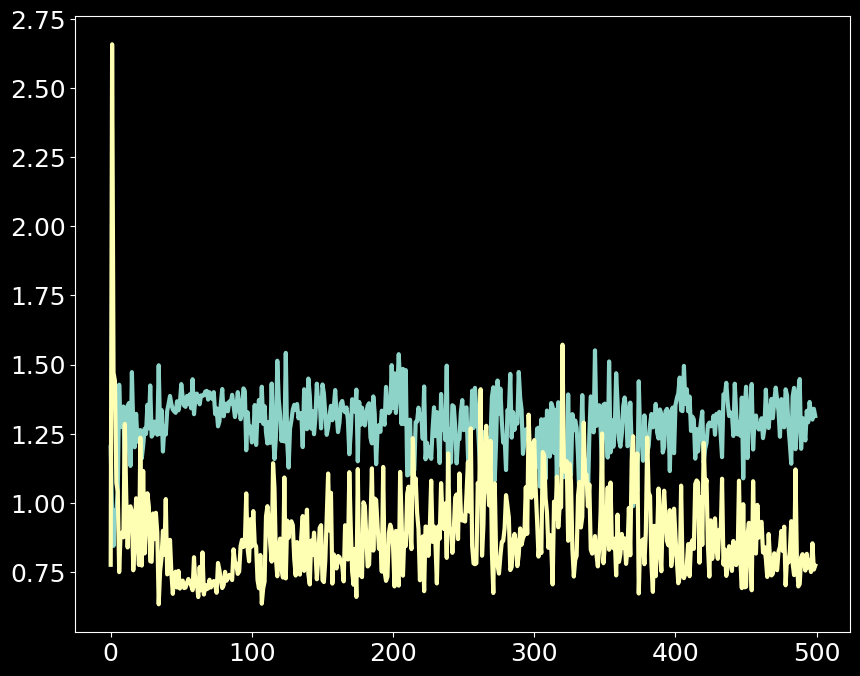

In [10]:
plt.figure(figsize=(10,8))
plt.plot(loss_d.detach())
plt.plot(loss_g.detach())

Now, we can visualize the samples that can be generated by drawing some random latent positions.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

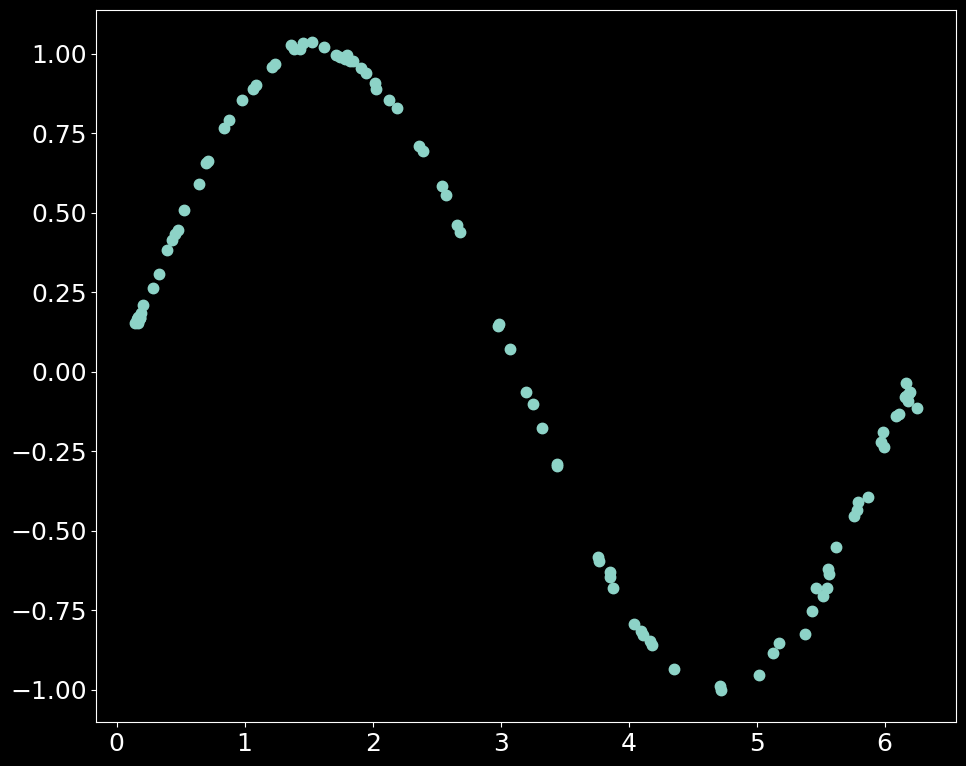

In [11]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.figure(figsize=(10,8))
plt.plot(generated_samples[:,0], generated_samples[:,1], '.')
plt.tight_layout()

As we can see, the randomly generated points closely follow the original distribution.

## Handwritten digits generator with GAN

Generative adversarial networks can also generate high-dimensional samples such as images. In this example, we are going to define a GAN to generate images of handwritten digits. For that, we will train the models using the infamous MNIST dataset. 

Again, we are going to make use of `torch` and `torchvision` . Notably, we will use `transforms` to obtain the training data and perform image conversions.

In [12]:
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import os

Since this example uses images in the training set, the models need to be more complex, with a larger number of parameters. This makes the training process slower, taking about two minutes per epoch when running on CPU. To reduce the training time, you can use a GPU to train the model if you have one available. The following piece of code allows to automatically select the best device available on your system.

In [13]:
device = ''
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Preparing the training data

The MNIST dataset consists of 28 × 28 pixel grayscale images of handwritten digits from 0 to 9. To use them with PyTorch, we need to convert them to Tensors. Also, in order to ensure adequate learning, it is always best to normalize the data. This is were we make use of `torchvision.transforms` in order to perfom thesse automatically while loading the data.

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

Now, as usual, we can load both the *training* and *testing* data with the datasets objects

In [16]:
batch_size = 32
# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

Here we plot some examples of the train set, to better understand the underlying data that we are working with.

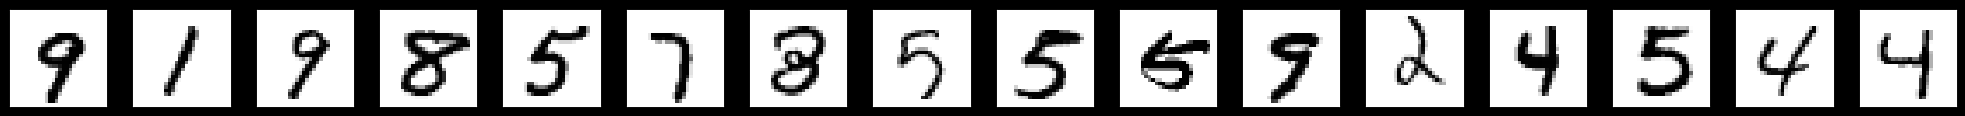

In [17]:
fig = plt.figure(figsize=(20,5))
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(1, 16, i+1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()    

### Implementing the discriminator and generator

Here, we are going to first define our *discriminator*. In our case, we will use an MLP, that will be responsible for receiving the images and trying to find which images are fake. Here, we propose the converse exercise of the previous one, as you need to implement your own architecture before training it.

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.2 - Discriminator architecture

> 1. Define an architecture of your choice for the discriminator
> 2. (Optional) Compare the use of feed-forward and convolutional architectures.
    
</div>

***

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        ######################
        # YOUR CODE GOES HERE
        ######################
        
        self.model = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        output = self.model(x)
        return output

To input the image coefficients into the MLP neural network, you vectorize them so that the neural network receives vectors with 784 coefficients. The vectorization occurs in the first line of `.forward()`, as the call to `x.view()` converts the shape of the input tensor. In this case, the original shape of the input x is 32 × 1 × 28 × 28, where 32 is the batch size you’ve set up. After the conversion, the shape of x becomes 32 × 784, with each line representing the coefficients of an image of the training set.

To run the discriminator model using the GPU, you have to instantiate it and send it to the GPU with .to(). To use a GPU when there’s one available, you can send the model to the device object you created earlier:

In [19]:
discriminator = Discriminator().to(device=device)

Since the generator is going to generate more complex data, it’s necessary to increase the dimensions of the input from the latent space. In this case, the generator is going to be fed a 100-dimensional input and will provide an output with 784 coefficients, which will be organized in a 28 × 28 tensor representing an image. 

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.3 - Generator architecture

> 1. Define an architecture of your choice for the generator
> 2. (Optional) Compare the use of feed-forward and convolutional architectures.
    
</div>

***

In [26]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        ######################
        # YOUR CODE GOES HERE
        ######################
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        #x = x.view(x.size(0), 100)
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [27]:
generator = Generator().to(device=device)

As usual, we define the training hyper-parameters that will condition our learning procedure.

In [28]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [29]:
latent_space_samples_plot = torch.randn((16, 100)).to(device=device)

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.4 - Training procedure

> 1. Implement the training procedure for the whole GAN

**Note:** This implementation should be extremely similar to question 1.1
    
</div>

***

In [30]:
from tqdm import tqdm

# Load trained NN when it exists, or train a new NN
if os.path.isfile('discriminator.pt') and os.path.isfile('generator.pt'):
    discriminator.load_state_dict(torch.load('./discriminator.pt'))
    generator.load_state_dict(torch.load('./generator.pt'))   
else:
    for epoch in tqdm(range(num_epochs)):
        for n, (real_samples, _) in tqdm(enumerate(train_loader), leave=False):
        
            ######################
            # YOUR CODE GOES HERE
            ######################
            
            # Train Discriminator
            discriminator.zero_grad()
            real_samples = real_samples.to(device=device)
            output_discriminator_real = discriminator(real_samples)
            loss_discriminator_real = loss_function(output_discriminator_real, torch.ones((batch_size, 1)).to(device=device))
            loss_discriminator_real.backward()

            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
            generated_samples = generator(latent_space_samples)
            output_discriminator_fake = discriminator(generated_samples)
            loss_discriminator_fake = loss_function(output_discriminator_fake, torch.zeros((batch_size, 1)).to(device=device))
            loss_discriminator_fake.backward()

            loss_discriminator = loss_discriminator_real + loss_discriminator_fake
            optimizer_discriminator.step()

            # Train Generator
            generator.zero_grad()
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
            generated_samples = generator(latent_space_samples)
            output_discriminator_fake = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_fake, torch.ones((batch_size, 1)).to(device=device))
            loss_generator.backward()
            optimizer_generator.step()

            # Show loss
            if n == batch_size - 1:
                tqdm.write(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                tqdm.write(f"Epoch: {epoch} Loss G.: {loss_generator}")

                                      
                                      
  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 Loss D.: 1.2081469297409058
Epoch: 0 Loss G.: 0.4347758889198303


                                              
                                              
  2%|▏         | 1/50 [00:17<14:19, 17.54s/it]

Epoch: 1 Loss D.: 1.5347785949707031
Epoch: 1 Loss G.: 1.2004199028015137


                                              
                                              
  4%|▍         | 2/50 [00:35<14:14, 17.81s/it]

Epoch: 2 Loss D.: 1.203827977180481
Epoch: 2 Loss G.: 1.3269470930099487


                                              
                                              
  6%|▌         | 3/50 [00:53<13:49, 17.64s/it]

Epoch: 3 Loss D.: 0.9364864230155945
Epoch: 3 Loss G.: 1.700078010559082


                                              
                                              
  8%|▊         | 4/50 [01:10<13:24, 17.48s/it]

Epoch: 4 Loss D.: 1.1883902549743652
Epoch: 4 Loss G.: 0.773419201374054


                                              
                                              
 10%|█         | 5/50 [01:27<12:58, 17.29s/it]

Epoch: 5 Loss D.: 1.2695945501327515
Epoch: 5 Loss G.: 1.0074505805969238


                                              
                                              
 12%|█▏        | 6/50 [01:45<12:50, 17.50s/it]

Epoch: 6 Loss D.: 1.019687294960022
Epoch: 6 Loss G.: 0.9816449284553528


                                              
                                              
 14%|█▍        | 7/50 [02:02<12:29, 17.43s/it]

Epoch: 7 Loss D.: 1.4191075563430786
Epoch: 7 Loss G.: 0.8715122938156128


                                              
                                              
 16%|█▌        | 8/50 [02:20<12:12, 17.43s/it]

Epoch: 8 Loss D.: 1.1861701011657715
Epoch: 8 Loss G.: 1.012906789779663


                                              
                                              
 18%|█▊        | 9/50 [02:37<11:52, 17.39s/it]

Epoch: 9 Loss D.: 1.117244005203247
Epoch: 9 Loss G.: 0.9861773252487183


                                               
                                               
 20%|██        | 10/50 [02:54<11:32, 17.30s/it]

Epoch: 10 Loss D.: 1.1806973218917847
Epoch: 10 Loss G.: 1.2621344327926636


                                               
                                               
 22%|██▏       | 11/50 [03:12<11:19, 17.43s/it]

Epoch: 11 Loss D.: 1.0895473957061768
Epoch: 11 Loss G.: 1.08931303024292


                                               
                                               
 24%|██▍       | 12/50 [03:28<10:51, 17.15s/it]

Epoch: 12 Loss D.: 1.0458502769470215
Epoch: 12 Loss G.: 0.9690191149711609


                                               
                                               
 26%|██▌       | 13/50 [03:44<10:16, 16.66s/it]

Epoch: 13 Loss D.: 1.1056187152862549
Epoch: 13 Loss G.: 1.0661425590515137


                                               
                                               
 28%|██▊       | 14/50 [04:00<09:59, 16.66s/it]

Epoch: 14 Loss D.: 1.1381639242172241
Epoch: 14 Loss G.: 0.9902376532554626


                                               
                                               
 30%|███       | 15/50 [04:16<09:34, 16.42s/it]

Epoch: 15 Loss D.: 0.9855489730834961
Epoch: 15 Loss G.: 1.1369116306304932


                                               
                                               
 32%|███▏      | 16/50 [04:31<09:02, 15.95s/it]

Epoch: 16 Loss D.: 1.2031714916229248
Epoch: 16 Loss G.: 1.012606143951416


                                               
                                               
 34%|███▍      | 17/50 [04:46<08:36, 15.64s/it]

Epoch: 17 Loss D.: 0.9276015758514404
Epoch: 17 Loss G.: 1.3247723579406738


                                               
                                               
 36%|███▌      | 18/50 [05:01<08:17, 15.56s/it]

Epoch: 18 Loss D.: 1.1058323383331299
Epoch: 18 Loss G.: 0.9526114463806152


                                               
                                               
 38%|███▊      | 19/50 [05:18<08:14, 15.96s/it]

Epoch: 19 Loss D.: 1.3399091958999634
Epoch: 19 Loss G.: 1.0682332515716553


                                               
                                               
 40%|████      | 20/50 [05:35<08:07, 16.25s/it]

Epoch: 20 Loss D.: 1.324690818786621
Epoch: 20 Loss G.: 0.87959885597229


                                               
                                               
 42%|████▏     | 21/50 [05:52<07:54, 16.36s/it]

Epoch: 21 Loss D.: 1.1133983135223389
Epoch: 21 Loss G.: 1.0495065450668335


                                               
                                               
 44%|████▍     | 22/50 [06:09<07:45, 16.63s/it]

Epoch: 22 Loss D.: 1.1927015781402588
Epoch: 22 Loss G.: 0.9572014808654785


                                               
                                               
 46%|████▌     | 23/50 [06:26<07:30, 16.68s/it]

Epoch: 23 Loss D.: 1.4071499109268188
Epoch: 23 Loss G.: 0.9629288911819458


                                               
                                               
 48%|████▊     | 24/50 [06:42<07:11, 16.61s/it]

Epoch: 24 Loss D.: 1.2011449337005615
Epoch: 24 Loss G.: 1.0233702659606934


                                               
                                               
 50%|█████     | 25/50 [07:00<07:05, 17.01s/it]

Epoch: 25 Loss D.: 1.1166144609451294
Epoch: 25 Loss G.: 0.8650134205818176


                                               
                                               
 52%|█████▏    | 26/50 [07:17<06:44, 16.87s/it]

Epoch: 26 Loss D.: 1.3440215587615967
Epoch: 26 Loss G.: 0.8264527916908264


                                               
                                               
 54%|█████▍    | 27/50 [07:33<06:23, 16.69s/it]

Epoch: 27 Loss D.: 1.2146410942077637
Epoch: 27 Loss G.: 0.9146674871444702


                                               
                                               
 56%|█████▌    | 28/50 [07:50<06:05, 16.60s/it]

Epoch: 28 Loss D.: 1.3783702850341797
Epoch: 28 Loss G.: 0.8242164850234985


                                               
                                               
 58%|█████▊    | 29/50 [08:06<05:48, 16.62s/it]

Epoch: 29 Loss D.: 1.1775286197662354
Epoch: 29 Loss G.: 1.072582483291626


                                               
                                               
 60%|██████    | 30/50 [08:23<05:35, 16.80s/it]

Epoch: 30 Loss D.: 1.308850884437561
Epoch: 30 Loss G.: 0.895112156867981


                                               
                                               
 62%|██████▏   | 31/50 [08:40<05:17, 16.69s/it]

Epoch: 31 Loss D.: 1.1688505411148071
Epoch: 31 Loss G.: 0.9383083581924438


                                               
                                               
 64%|██████▍   | 32/50 [08:57<05:03, 16.84s/it]

Epoch: 32 Loss D.: 1.313318133354187
Epoch: 32 Loss G.: 0.8434984087944031


                                               
                                               
 66%|██████▌   | 33/50 [09:14<04:45, 16.81s/it]

Epoch: 33 Loss D.: 1.361663818359375
Epoch: 33 Loss G.: 0.8610022068023682


                                               
                                               
 68%|██████▊   | 34/50 [09:32<04:33, 17.09s/it]

Epoch: 34 Loss D.: 1.1439927816390991
Epoch: 34 Loss G.: 1.095088243484497


                                               
                                               
 70%|███████   | 35/50 [09:49<04:18, 17.24s/it]

Epoch: 35 Loss D.: 1.2083461284637451
Epoch: 35 Loss G.: 0.970126748085022


                                               
                                               
 72%|███████▏  | 36/50 [10:06<04:00, 17.19s/it]

Epoch: 36 Loss D.: 1.2063441276550293
Epoch: 36 Loss G.: 0.9132252931594849


                                               
                                               
 74%|███████▍  | 37/50 [10:23<03:43, 17.23s/it]

Epoch: 37 Loss D.: 1.2451884746551514
Epoch: 37 Loss G.: 0.8671609163284302


                                               
                                               
 76%|███████▌  | 38/50 [10:41<03:26, 17.21s/it]

Epoch: 38 Loss D.: 1.2209495306015015
Epoch: 38 Loss G.: 0.8860929012298584


                                               
                                               
 78%|███████▊  | 39/50 [10:58<03:08, 17.15s/it]

Epoch: 39 Loss D.: 1.1902762651443481
Epoch: 39 Loss G.: 0.8358555436134338


                                               
                                               
 80%|████████  | 40/50 [11:15<02:50, 17.08s/it]

Epoch: 40 Loss D.: 1.1597790718078613
Epoch: 40 Loss G.: 0.8591098785400391


                                               
                                               
 82%|████████▏ | 41/50 [11:30<02:28, 16.54s/it]

Epoch: 41 Loss D.: 1.2819530963897705
Epoch: 41 Loss G.: 0.644263744354248


                                               
                                               
 84%|████████▍ | 42/50 [11:45<02:09, 16.19s/it]

Epoch: 42 Loss D.: 1.384197473526001
Epoch: 42 Loss G.: 0.9183159470558167


                                               
                                               
 86%|████████▌ | 43/50 [12:01<01:52, 16.02s/it]

Epoch: 43 Loss D.: 1.3854224681854248
Epoch: 43 Loss G.: 0.8934587240219116


                                               
                                               
 88%|████████▊ | 44/50 [12:17<01:35, 15.98s/it]

Epoch: 44 Loss D.: 1.2408592700958252
Epoch: 44 Loss G.: 0.8618651628494263


                                               
                                               
 90%|█████████ | 45/50 [12:33<01:20, 16.09s/it]

Epoch: 45 Loss D.: 1.2192702293395996
Epoch: 45 Loss G.: 0.9094656109809875


                                               
                                               
 92%|█████████▏| 46/50 [12:50<01:04, 16.21s/it]

Epoch: 46 Loss D.: 1.1348642110824585
Epoch: 46 Loss G.: 0.8232812881469727


                                               
                                               
 94%|█████████▍| 47/50 [13:07<00:49, 16.54s/it]

Epoch: 47 Loss D.: 1.2465031147003174
Epoch: 47 Loss G.: 0.9281205534934998


                                               
                                               
 96%|█████████▌| 48/50 [13:23<00:32, 16.44s/it]

Epoch: 48 Loss D.: 1.3088269233703613
Epoch: 48 Loss G.: 0.8169792890548706


                                               
                                               
 98%|█████████▊| 49/50 [13:40<00:16, 16.65s/it]

Epoch: 49 Loss D.: 1.2904682159423828
Epoch: 49 Loss G.: 0.9139612913131714


100%|██████████| 50/50 [13:57<00:00, 16.75s/it]


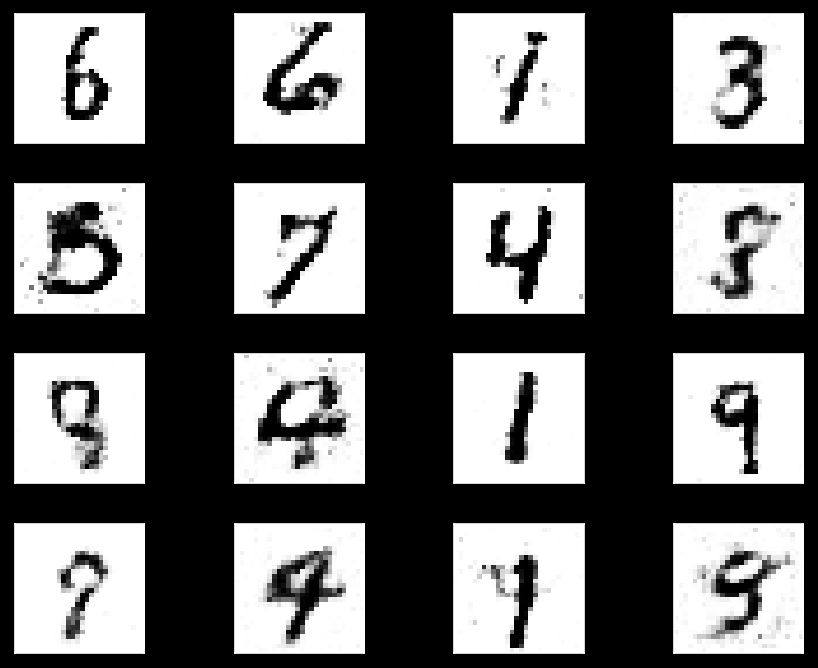

In [31]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)

generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()

plt.figure(dpi=150)
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [17]:
# Save trained NN parameters
torch.save(generator.state_dict(), 'generator.pt')
torch.save(discriminator.state_dict(), 'discriminator.pt')